VGG模型：
- 非结构化剪枝+层敏感度分析
- 结构化剪枝+层敏感度分析
- 不同数据集



In [2]:
import os
from torchvision import models
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
from copy import deepcopy
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim

# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 2. 挂载 Google Drive（如果还没挂载的话）

print(device)

cuda


In [ ]:
import torchvision
import torchvision.transforms as transforms

# 加载 CIFAR10 数据集
batch_size = 64

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='/bohr/cifar10-h7hf/v2', train=True, download=True, transform=transform_train)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='/bohr/cifar10-h7hf/v2', train=False, download=True, transform=transform_test)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)
n_test = len(testset)
example_input = (testset[0])

100%|██████████| 170M/170M [00:04<00:00, 38.4MB/s]


In [3]:
vgg11_cfg = [64, 'M', 128, 'M', 256, 'M', 512, 'M', 512, 'M']
class VGG11(nn.Module):
    def __init__(self):
        super(VGG11, self).__init__()
        self.features = self._make_layers(vgg11_cfg)
        self.classifier = nn.Linear(512, 10)  # CIFAR-10 has 10 classes

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [
                    nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                    nn.BatchNorm2d(x),
                    nn.ReLU(inplace=True)
                ]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [5]:
import torch
import torch.nn as nn

model = VGG11()

print("📊 Conv2d layers total params（单位：K）\n")
print(f"{'Layer Name':<30} | {'Params (K)':>12}")
print("-" * 45)

for name, module in model.named_modules():
    if isinstance(module, nn.Conv2d):
        params = sum(p.numel() for p in module.parameters())
        params_k = params / 1e3  # 转换为 K
        print(f"{name:<30} | {params_k:>10.2f}K")


📊 Conv2d 层参数统计（单位：K）

Layer Name                     |   Params (K)
---------------------------------------------
features.0                     |       1.79K
features.4                     |      73.86K
features.8                     |     295.17K
features.12                    |    1180.16K
features.16                    |    2359.81K


### ✂️Part1 Get layer-sensitivity
- 1.1、Training

In [ ]:
# ---------- 1. 初始化模型 ----------
model = VGG11().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

# ---------- 2. 训练 ----------
EPOCHS = 50
best_acc = 0.0

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step()

# ---------- 3.测试 ----------
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    acc = 100. * correct / total
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {running_loss:.3f} - Test Acc: {acc:.2f}%")

    # 保存最好的模型
    if acc > best_acc:
        best_acc = acc
        from google.colab import drive
        drive.mount('/content/drive')
        # 定义保存路径
        save_path = "/content/drive/MyDrive/第二次尝试/Independent_VGG11_CIFAR10.pth"
        # 保存模型参数
        torch.save(model.state_dict(), save_path)

print("Training complete. Best accuracy: {:.2f}%".format(best_acc))

Epoch 1/50 - Loss: 1667.970 - Test Acc: 42.64%
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 2/50 - Loss: 1042.606 - Test Acc: 53.07%
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 3/50 - Loss: 817.708 - Test Acc: 66.87%
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 4/50 - Loss: 697.259 - Test Acc: 69.39%
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 5/50 - Loss: 624.137 - Test Acc: 75.20%
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 6/50 - Loss: 574.147 - Test Acc: 73.04%
Epoch 7/50 - Loss: 543.571 - Test Acc: 74.74%
Epoch 8/50 - Loss: 520.761 - Te

##### 加载模型

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
model = VGG11()
model.load_state_dict(torch.load('/content/drive/MyDrive/第二次尝试/Independent_VGG11_CIFAR10.pth', map_location=torch.device('cpu')))

Mounted at /content/drive


<All keys matched successfully>

In [ ]:
# Second time : run
import time
def test(model, test_loader, debug = False):
    model.eval()
    correct = 0
    total = 0
    model.to(device)
    with torch.no_grad():
        start_time = time.time()
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        end_time = time.time()
    accuracy = 100 * correct / total
    time_cost = end_time - start_time
    if debug:
        print('Accuracy of the network on the %d test images: %.2f %%' % (n_test, accuracy))
        print('Time cost: %.2f s' % time_cost)
    return accuracy, time_cost

In [ ]:
acc,time_cost = test(model,test_loader)
baseline_acc = acc

In [ ]:
# Second time : no run
baseline_acc

83.43

1.2、Start pruning

In [ ]:
conv_layers = [(name, m) for name, m in model.features.named_modules() if isinstance(m, nn.Conv2d)]
conv_layers

[('0', Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('4', Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('8', Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('12', Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('16', Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))]

In [ ]:
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
from copy import deepcopy

def compute_layer_sensitivities_earlystop(
    model,
    prune_rates,
    device,
    testloader,
    test_fn,
    threshold=12.0,   # 阈值：相对 baseline 的精度下降超过多少百分比就停
    verbose=True
):
    """
    计算各卷积层在不同剪枝率下的敏感度(Δacc)，并在精度下降超过阈值时提前停止，
    将“上一个未越线的剪枝率”作为该层的敏感度。

    返回:
      results: dict
        {
          layer_idx: {
            'layer_name': str,
            'baseline_acc': float,
            'chosen_sensitivity_rate': float,   # 该层最终选定的敏感度剪枝率（上一个安全rate）
            'early_stopped': bool,              # 是否提前停止
            'per_rate': {rate: {'acc': float, 'delta_acc': float}},  # 已评估到的各rate
          },
          ...
        }
    """
    # 1) baseline
    base_model = deepcopy(model).to(device).eval()
    with torch.no_grad():
        baseline_acc = 83.43
    if verbose:
        print(f"[Baseline] Accuracy: {baseline_acc:.2f}%")

    # 2) 找卷积层
    conv_layers = [(name, m) for name, m in base_model.features.named_modules() if isinstance(m, nn.Conv2d)]
    results = {}

    # 3) 逐层评估
    for i, (layer_name, _) in enumerate(conv_layers):
        per_rate_stats = {}
        last_safe_rate = 0.0
        early_stopped = False

        if verbose:
            print(f"\n[Layer {i}] -> {layer_name}")

        for rate in prune_rates:
            # 独立拷贝与评估
            temp_model = deepcopy(base_model).to(device).eval()

            # 剪枝目标层
            target_layer = dict(temp_model.features.named_modules())[layer_name]
            prune.ln_structured(target_layer, name='weight', amount=rate, n=2, dim=0)

            # 评估精度
            with torch.no_grad():
                acc = test_fn(temp_model, testloader)[0]
            delta_acc = baseline_acc - acc  # 相对 baseline 的下降

            per_rate_stats[rate] = {'acc': acc, 'delta_acc': delta_acc}

            if verbose:
                print(f"  rate={rate:.2f} -> acc={acc:.2f}% | Δacc={delta_acc:.2f}% "
                      f"| safe_until={last_safe_rate:.2f}")

            # 判定是否越过阈值
            if delta_acc > threshold:
                # 越线：本层提早结束，敏感度取“上一个安全剪枝率”
                early_stopped = True
                if verbose:
                    print(f"  -> Δacc {delta_acc:.2f}% > {threshold:.2f}%: early stop. "
                          f"Chosen sensitivity = {last_safe_rate:.2f}")
                break
            else:
                # 未越线：更新“上一个安全剪枝率”
                last_safe_rate = rate

        # 如果从未越线，敏感度就取已评估的最大剪枝率
        chosen_sensitivity_rate = last_safe_rate

        results[i] = {
            'layer_name': layer_name,
            'baseline_acc': baseline_acc,
            'chosen_sensitivity_rate': chosen_sensitivity_rate,
            'early_stopped': early_stopped,
            'per_rate': per_rate_stats
        }

        if verbose:
            print(f"[Layer {i} Summary] chosen_sensitivity_rate = {chosen_sensitivity_rate:.2f}, "
                  f"early_stopped={early_stopped}")

    return results


In [ ]:
basemodel = deepcopy(model)

In [ ]:
prune_rates = [0.1, 0.3, 0.5, 0.7, 0.9]
results = compute_layer_sensitivities_earlystop(
    model=basemodel,
    prune_rates=prune_rates,
    device=device,
    testloader=test_loader,
    test_fn=test,
    threshold=12.0,
    verbose=True
)

# 取第0层的敏感度
print("-----Sensitivity in layer0-----")

print(results[0]['layer_name'], results[0]['chosen_sensitivity_rate'])


[Baseline] Accuracy: 83.43%

[Layer 0] -> 0
  rate=0.10 -> acc=83.47% | Δacc=-0.04% | safe_until=0.00
  rate=0.30 -> acc=82.69% | Δacc=0.74% | safe_until=0.10
  rate=0.50 -> acc=80.54% | Δacc=2.89% | safe_until=0.30
  rate=0.70 -> acc=53.36% | Δacc=30.07% | safe_until=0.50
  -> Δacc 30.07% > 12.00%: early stop. Chosen sensitivity = 0.50
[Layer 0 Summary] chosen_sensitivity_rate = 0.50, early_stopped=True

[Layer 1] -> 4
  rate=0.10 -> acc=81.38% | Δacc=2.05% | safe_until=0.00
  rate=0.30 -> acc=51.62% | Δacc=31.81% | safe_until=0.10
  -> Δacc 31.81% > 12.00%: early stop. Chosen sensitivity = 0.10
[Layer 1 Summary] chosen_sensitivity_rate = 0.10, early_stopped=True

[Layer 2] -> 8
  rate=0.10 -> acc=81.86% | Δacc=1.57% | safe_until=0.00
  rate=0.30 -> acc=76.85% | Δacc=6.58% | safe_until=0.10
  rate=0.50 -> acc=43.76% | Δacc=39.67% | safe_until=0.30
  -> Δacc 39.67% > 12.00%: early stop. Chosen sensitivity = 0.30
[Layer 2 Summary] chosen_sensitivity_rate = 0.30, early_stopped=True

[Lay

### Part2：Prune based on sensitivity
现在我们已经得到各层敏感度；开始剪枝+量化
- (一)：第一种剪枝方式：全局剪枝（使用0.7）
- (二)：第二种剪枝方式：迭代剪枝

In [ ]:
#Second time: Run!!!
vgg11_cfg = [64, 'M', 128, 'M', 256, 'M', 512, 'M', 512, 'M']
class VGG11(nn.Module):
    def __init__(self):
        super(VGG11, self).__init__()
        self.features = self._make_layers(vgg11_cfg)
        self.classifier = nn.Linear(512, 10)  # CIFAR-10 has 10 classes

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [
                    nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                    nn.BatchNorm2d(x),
                    nn.ReLU(inplace=True)
                ]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [ ]:
#Second time: Run!!!
from google.colab import drive
drive.mount('/content/drive')
model = VGG11()
state = torch.load("/content/drive/MyDrive/第二次尝试/Independent_VGG11_CIFAR10.pth", map_location='cpu')
model.load_state_dict(state)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<All keys matched successfully>

全局剪枝

In [ ]:
#Second time: Run!!!
# 收集所有 Conv2d 层
parameters_to_prune = []
for name, module in model.features.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        parameters_to_prune.append((module, 'weight'))

# 执行全局剪枝（70%）
prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.7
)
# 移除掩码（使剪枝永久生效）
for module, param_name in parameters_to_prune:
    prune.remove(module, param_name)
#128807306卷积：9220480
global_acc = test(model,test_loader)

print(f"After pruning，Accuracy and inference time is :{global_acc}")

After pruning，Accuracy and inference time is :(82.68, 3.988576889038086)


In [ ]:
#Second time: Run!!!
#保存全局剪枝后的模型；
torch.save(model.state_dict(), "/content/drive/MyDrive/第二次尝试/Independent_V11_C10_afterGlobalPrune.pth")

In [ ]:
#加载剪枝之后的模型
model = VGG11()
model.load_state_dict(torch.load("/content/drive/MyDrive/第二次尝试/Independent_V11_C10_afterGlobalPrune.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
def count_zero_weights_pruned(model):
    total, zeros = 0, 0
    for name, module in model.named_modules():
        if hasattr(module, "weight"):
            w = module.weight.detach()  # 这是带 mask 的权重
            total += w.numel()
            zeros += torch.sum(w == 0).item()
    return total, zeros, 100 * zeros / total

total, zeros, zero_ratio = count_zero_weights_pruned(model)
print(f"Total weights: {total}")
print(f"Zero weights: {zeros}")
print(f"Sparsity: {zero_ratio:.2f}%")


Total weights: 3915904
Zero weights: 2736518
Sparsity: 69.88%


In [ ]:
#Fine-tunning
model_finetunning = deepcopy(model)
model_finetunning = model_finetunning.to(device)

# 可选：冻结特征提取部分
for param in model_finetunning.features.parameters():
    param.requires_grad = False

# -----------------------
# 3. 定义损失和优化器
# -----------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_finetunning.parameters(), lr=0.0001)

# -----------------------
# 4. 模型训练
# -----------------------
for epoch in range(10):  # 可根据需要改epoch数
    model_finetunning.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_finetunning(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:  # 每100个mini-batch打印一次loss
            print(f"[Epoch {epoch+1}, Batch {i+1}] loss: {running_loss/100:.3f}")
            running_loss = 0.0

print("Finished Training")

[Epoch 1, Batch 100] loss: 0.415
[Epoch 1, Batch 200] loss: 0.407
[Epoch 1, Batch 300] loss: 0.413
[Epoch 1, Batch 400] loss: 0.402
[Epoch 1, Batch 500] loss: 0.402
[Epoch 1, Batch 600] loss: 0.407
[Epoch 1, Batch 700] loss: 0.395
[Epoch 2, Batch 100] loss: 0.410
[Epoch 2, Batch 200] loss: 0.395
[Epoch 2, Batch 300] loss: 0.385
[Epoch 2, Batch 400] loss: 0.383
[Epoch 2, Batch 500] loss: 0.397
[Epoch 2, Batch 600] loss: 0.379
[Epoch 2, Batch 700] loss: 0.381
[Epoch 3, Batch 100] loss: 0.374
[Epoch 3, Batch 200] loss: 0.390
[Epoch 3, Batch 300] loss: 0.389
[Epoch 3, Batch 400] loss: 0.390
[Epoch 3, Batch 500] loss: 0.383
[Epoch 3, Batch 600] loss: 0.391
[Epoch 3, Batch 700] loss: 0.380
[Epoch 4, Batch 100] loss: 0.374
[Epoch 4, Batch 200] loss: 0.381
[Epoch 4, Batch 300] loss: 0.376
[Epoch 4, Batch 400] loss: 0.393
[Epoch 4, Batch 500] loss: 0.373
[Epoch 4, Batch 600] loss: 0.398
[Epoch 4, Batch 700] loss: 0.386
[Epoch 5, Batch 100] loss: 0.374
[Epoch 5, Batch 200] loss: 0.383
[Epoch 5, 

In [ ]:
global_acc_2 = test(model_finetunning,test_loader)
print(f"After fine-tunning，（Global）Accuracy and inference time is :{global_acc_2}")

After fine-tunning，（Global）Accuracy and inference time is :(85.5, 4.137554407119751)


In [ ]:
total, zeros, zero_ratio = count_zero_weights_pruned(model_finetunning)
print(f"Total weights: {total}")
print(f"Zero weights: {zeros}")
print(f"Sparsity: {zero_ratio:.2f}%")

Total weights: 3915904
Zero weights: 2736518
Sparsity: 69.88%


If iterative Pruning:

In [ ]:
#稀疏度计算
def calculate_model_sparsity(model):
    total_params = 0
    zero_params = 0

    for name, param in model.named_parameters():
        if "weight" in name and param.requires_grad:
            num_params = param.numel()
            num_zeros = torch.sum(param == 0).item()
            total_params += num_params
            zero_params += num_zeros
            layer_sparsity = 100.0 * num_zeros / num_params
            print(f"{name:40} | Sparsity: {layer_sparsity:.2f}% ({num_zeros}/{num_params})")

    total_sparsity = 100.0 * zero_params / total_params
    print(f"\n🔍 Total model sparsity: {total_sparsity:.2f}% ({zero_params}/{total_params})")

    return total_sparsity
# 假设你有一个剪枝后的模型
sparsity = calculate_model_sparsity(model_finetunning)

classifier.weight                        | Sparsity: 0.00% (0/5120)

🔍 Total model sparsity: 0.00% (0/5120)


### PART3. Then start quantization:
- PTSQ✅
- PTDQ❌

In [ ]:
import copy
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time
import copy
import torch.ao.quantization.quantize_fx as quantize_fx
import os
from torch.ao.quantization import (
  get_default_qconfig_mapping,
  get_default_qat_qconfig_mapping,
  QConfigMapping,
)
model.to("cpu")
model_to_quantize_ptsq = copy.deepcopy(model)
model_to_quantize_ptsq.eval()
qconfig_mapping = get_default_qconfig_mapping("qnnpack")
model_prepared_ptsq = quantize_fx.prepare_fx(model_to_quantize_ptsq, qconfig_mapping, example_input)
# 这里使用全部的训练数据来对模型进行校准
# 注意：校准并不是训练，所以我们不需要对模型做反向传播
model_prepared_ptsq.eval()
with torch.no_grad():
    for images, labels in train_loader:
        images = images.cpu()
        model_prepared_ptsq(images)

model_quantized_ptsq = quantize_fx.convert_fx(model_prepared_ptsq)

In [ ]:
# Test our PTSQ model
print('PTSQ model:')
accuracy, time_cost = test(model_quantized_ptsq, test_loader)

print(f'Accuracy: {accuracy:.2f}%, Time cost: {time_cost:.2f} s')

### OTHER WORKS

In [ ]:
basemodel = models.vgg11()  # 或者你自定义的 VGG11-CIFAR 版本

# 如果你之前做了修改（比如分类数不同），需要一致设置：
basemodel.classifier[6] = torch.nn.Linear(4096, 10)  # CIFAR-10 分类任务

# 4. 加载参数
save_path = "/content/drive/MyDrive/模型/VGG11_CIFAR.pth"
basemodel.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [ ]:
# 测试函数
def test_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            pred = output.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return 100 * correct / total

In [ ]:
# 剪枝率列表
prune_rates = [0.1, 0.3, 0.5, 0.7, 0.9]

# 找到所有Conv层
conv_layers = [(name, m) for name, m in basemodel.features.named_modules() if isinstance(m, nn.Conv2d)]
conv_layers

[('0', Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('3', Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('6', Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('8', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('11', Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('13', Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('16', Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('18', Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))]

In [ ]:
print("-----VGG11-----")

# 对每个Conv层进行多种剪枝测试
for i, (layer_name, layer) in enumerate(conv_layers):
    for rate in prune_rates:
        # 深拷贝模型
        model = deepcopy(basemodel)
        model.to(device)
        model.eval()
        # 获取当前层对象
        target_layer = dict(model.features.named_modules())[layer_name]
        # 执行剪枝
        prune.ln_structured(target_layer, name='weight', amount=rate, n=2, dim=0)
        # 评估剪枝后模型的准确率
        acc = test_accuracy(model, testloader)
        print(f"[Layer {i}] Pruned {layer_name} with {int(rate*100)}% -> Accuracy: {acc:.2f}%,,,,,and target_layer is {target_layer}")

-----VGG11-----
[Layer 0] Pruned 0 with 10% -> Accuracy: 86.11%,,,,,and target_layer is Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
[Layer 0] Pruned 0 with 30% -> Accuracy: 84.99%,,,,,and target_layer is Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
[Layer 0] Pruned 0 with 50% -> Accuracy: 80.98%,,,,,and target_layer is Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
[Layer 0] Pruned 0 with 70% -> Accuracy: 64.32%,,,,,and target_layer is Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
[Layer 0] Pruned 0 with 90% -> Accuracy: 10.86%,,,,,and target_layer is Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
[Layer 1] Pruned 3 with 10% -> Accuracy: 85.72%,,,,,and target_layer is Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
[Layer 1] Pruned 3 with 30% -> Accuracy: 83.99%,,,,,and target_layer is Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
[Layer 1] Pruned 3 wi

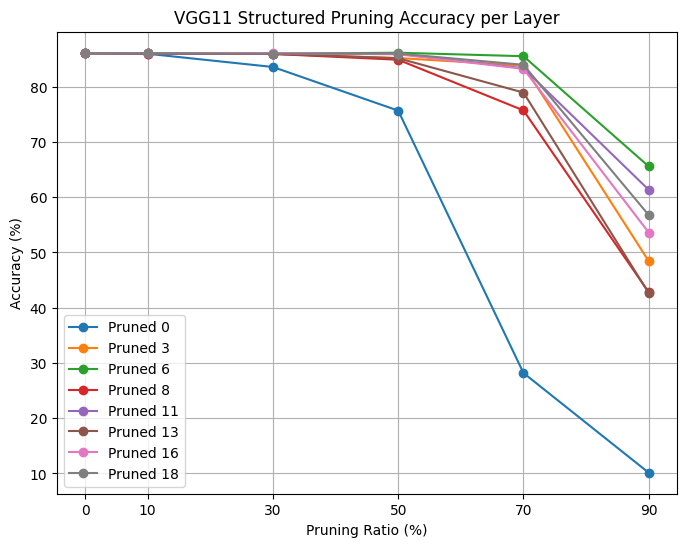

In [ ]:
import matplotlib.pyplot as plt

# 剪枝比例
prune_ratios = [0,10, 30, 50, 70, 90]

Un_accuracy_data = {
    "Pruned 0":  [86.06,85.96, 83.57, 75.67, 28.19, 10.14],
    "Pruned 3":  [86.06,86.06, 85.92, 85.19, 83.82, 48.44],
    "Pruned 6":  [86.06,86.03, 85.97, 86.15, 85.52, 65.57],
    "Pruned 8":  [86.06,85.99, 85.93, 84.88, 75.71, 42.80],
    "Pruned 11": [86.06,86.01, 85.99, 85.98, 83.34, 61.34],
    "Pruned 13": [86.06,86.04, 85.96, 85.15, 78.94, 42.66],
    "Pruned 16": [86.06,86.08, 86.09, 85.86, 83.24, 53.61],
    "Pruned 18": [86.06,86.08, 85.98, 86.00, 83.96, 56.77]
}
# 绘图
plt.figure(figsize=(8, 6))
for layer, acc_list in Un_accuracy_data.items():
    plt.plot(prune_ratios, acc_list, marker='o', label=layer)

# 图表设置
plt.title("VGG11 Structured Pruning Accuracy per Layer")
plt.xlabel("Pruning Ratio (%)")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.xticks(prune_ratios)

plt.show()

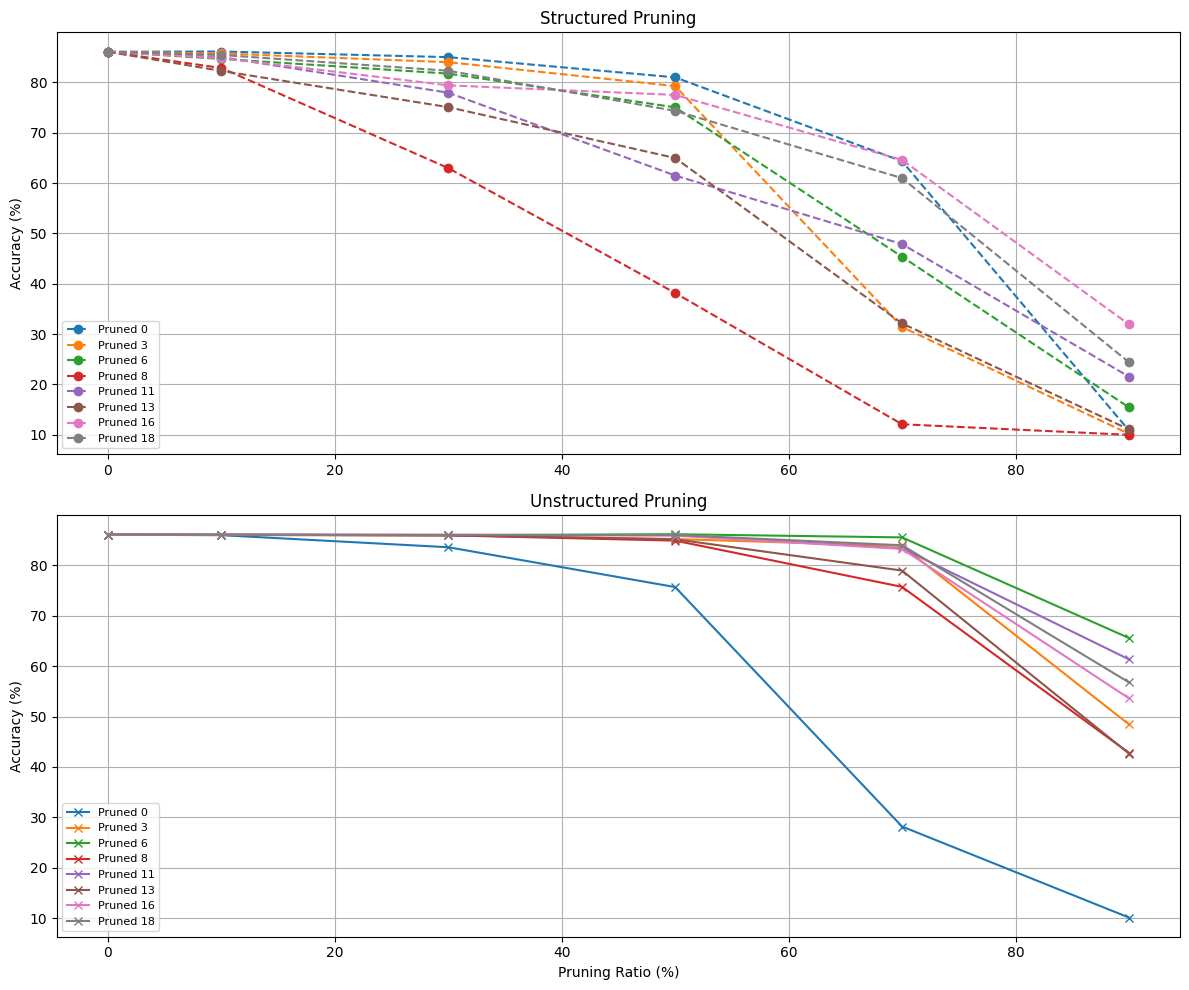

In [ ]:
import matplotlib.pyplot as plt

# 剪枝比例
prune_ratios = [0, 10, 30, 50, 70, 90]

# 每层的accuracy数据
S_accuracy_data = {
    "Pruned 0":  [86.06,86.11, 84.99, 80.98, 64.32, 10.86],
    "Pruned 3":  [86.06,85.72, 83.99, 79.24, 31.41, 10.20],
    "Pruned 6":  [86.06,84.64, 81.72, 75.02, 45.36, 15.45],
    "Pruned 8":  [86.06,82.83, 62.96, 38.16, 12.10, 10.00],
    "Pruned 11": [86.06,85.00, 77.93, 61.49, 47.87, 21.56],
    "Pruned 13": [86.06,82.25, 75.06, 64.97, 32.12, 11.08],
    "Pruned 16": [86.06,84.80, 79.39, 77.49, 64.58, 31.93],
    "Pruned 18": [86.06,85.42, 82.29, 74.33, 60.97, 24.41]
}

# 创建画布和子图（2行1列）
plt.figure(figsize=(12, 10))

# 第一个子图：结构化剪枝
plt.subplot(2, 1, 1)
for layer in S_accuracy_data:
    plt.plot(prune_ratios, S_accuracy_data[layer], linestyle='--', marker='o', label=layer)
plt.title("Structured Pruning")
plt.ylabel("Accuracy (%)")
plt.legend(loc='lower left', fontsize=8)
plt.grid(True)

# 第二个子图：非结构化剪枝
plt.subplot(2, 1, 2)
for layer in Un_accuracy_data:
    plt.plot(prune_ratios, Un_accuracy_data[layer], linestyle='-', marker='x', label=layer)
plt.title("Unstructured Pruning")
plt.xlabel("Pruning Ratio (%)")
plt.ylabel("Accuracy (%)")
plt.legend(loc='lower left', fontsize=8)
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
#8，11，13不做剪枝，其他剪枝50%
#先找到8，11，13层
print(basemodel)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [ ]:
# 找到所有Conv层
model = deepcopy(basemodel)
model = model.to(device)

conv_layers = [(name, m) for name, m in model.features.named_modules() if isinstance(m, nn.Conv2d)]
target_layers = [conv_layers[i] for i in [0, 1, 2, 6, 7]]
print(target_layers)

[('0', Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('3', Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('6', Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('16', Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('18', Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))]


In [ ]:
for i, (layer_name, layer) in enumerate(target_layers):
  target_layer = dict(model.features.named_modules())[layer_name]
  prune.ln_structured(target_layer,name="weight",amount = 0.5, n=2, dim=1)
  prune.remove(target_layer, 'weight')

acc_after_target = test_accuracy(model,testloader)
acc_after_target#先查看一下准确率

19.3

In [ ]:
#查看剪枝之后的权重
for i, (layer_name, layer) in enumerate(target_layers):
  target_layer = dict(model.features.named_modules())[layer_name]
  print("i")
  print(target_layer.weight)
  if i==3:
    break

i
tensor([[[[ 0.0000,  0.0000, -0.0000],
          [ 0.0000,  0.0000, -0.0000],
          [-0.0000,  0.0000, -0.0000]],

         [[ 0.4015, -0.0461, -0.6842],
          [ 0.4442,  0.4478, -0.7949],
          [ 0.1129,  0.4917, -0.3705]],

         [[ 0.0000, -0.0000, -0.0000],
          [ 0.0000,  0.0000, -0.0000],
          [-0.0000,  0.0000, -0.0000]]],


        [[[-0.0000, -0.0000,  0.0000],
          [-0.0000, -0.0000,  0.0000],
          [-0.0000, -0.0000,  0.0000]],

         [[-0.5740, -0.3998,  0.7708],
          [-0.8758, -0.3668,  1.1098],
          [-0.5186, -0.0801,  0.9228]],

         [[-0.0000, -0.0000,  0.0000],
          [-0.0000, -0.0000,  0.0000],
          [-0.0000, -0.0000,  0.0000]]],


        [[[ 0.0000, -0.0000, -0.0000],
          [ 0.0000,  0.0000, -0.0000],
          [-0.0000,  0.0000, -0.0000]],

         [[ 0.0290, -0.4797, -0.5490],
          [ 0.5363,  0.2973, -0.3728],
          [ 0.1776,  0.4145, -0.0436]],

         [[ 0.0000, -0.0000, -0.0000],
   

In [ ]:
#Fine-tunning
model_finetunning = deepcopy(model)
model_finetunning = model_finetunning.to(device)

# 可选：冻结特征提取部分
for param in model_finetunning.features.parameters():
    param.requires_grad = False

# -----------------------
# 3. 定义损失和优化器
# -----------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_finetunning.parameters(), lr=0.0001)

# -----------------------
# 4. 模型训练
# -----------------------
for epoch in range(10):  # 可根据需要改epoch数
    model_finetunning.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_finetunning(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:  # 每100个mini-batch打印一次loss
            print(f"[Epoch {epoch+1}, Batch {i+1}] loss: {running_loss/100:.3f}")
            running_loss = 0.0

print("Finished Training")

[Epoch 1, Batch 100] loss: 1.366
[Epoch 1, Batch 200] loss: 1.029
[Epoch 1, Batch 300] loss: 0.997
[Epoch 1, Batch 400] loss: 0.928
[Epoch 1, Batch 500] loss: 0.914
[Epoch 1, Batch 600] loss: 0.866
[Epoch 1, Batch 700] loss: 0.859
[Epoch 2, Batch 100] loss: 0.676
[Epoch 2, Batch 200] loss: 0.666
[Epoch 2, Batch 300] loss: 0.674
[Epoch 2, Batch 400] loss: 0.666
[Epoch 2, Batch 500] loss: 0.659
[Epoch 2, Batch 600] loss: 0.660
[Epoch 2, Batch 700] loss: 0.684
[Epoch 3, Batch 100] loss: 0.488
[Epoch 3, Batch 200] loss: 0.463
[Epoch 3, Batch 300] loss: 0.494
[Epoch 3, Batch 400] loss: 0.472
[Epoch 3, Batch 500] loss: 0.496
[Epoch 3, Batch 600] loss: 0.491
[Epoch 3, Batch 700] loss: 0.511
[Epoch 4, Batch 100] loss: 0.334
[Epoch 4, Batch 200] loss: 0.327
[Epoch 4, Batch 300] loss: 0.325
[Epoch 4, Batch 400] loss: 0.345
[Epoch 4, Batch 500] loss: 0.353
[Epoch 4, Batch 600] loss: 0.338
[Epoch 4, Batch 700] loss: 0.346
[Epoch 5, Batch 100] loss: 0.217
[Epoch 5, Batch 200] loss: 0.209
[Epoch 5, 

In [ ]:
#稀疏度计算
def calculate_model_sparsity(model):
    total_params = 0
    zero_params = 0

    for name, param in model.named_parameters():
        if "weight" in name and param.requires_grad:
            num_params = param.numel()
            num_zeros = torch.sum(param == 0).item()
            total_params += num_params
            zero_params += num_zeros
            layer_sparsity = 100.0 * num_zeros / num_params
            print(f"{name:40} | Sparsity: {layer_sparsity:.2f}% ({num_zeros}/{num_params})")

    total_sparsity = 100.0 * zero_params / total_params
    print(f"\n🔍 Total model sparsity: {total_sparsity:.2f}% ({zero_params}/{total_params})")

    return total_sparsity
# 假设你有一个剪枝后的模型
sparsity = calculate_model_sparsity(model)


features.0.weight                        | Sparsity: 66.67% (1152/1728)
features.3.weight                        | Sparsity: 50.00% (36864/73728)
features.6.weight                        | Sparsity: 50.00% (147456/294912)
features.8.weight                        | Sparsity: 0.00% (0/589824)
features.11.weight                       | Sparsity: 0.00% (0/1179648)
features.13.weight                       | Sparsity: 0.00% (0/2359296)
features.16.weight                       | Sparsity: 50.00% (1179648/2359296)
features.18.weight                       | Sparsity: 50.00% (1179648/2359296)
classifier.0.weight                      | Sparsity: 0.00% (0/102760448)
classifier.3.weight                      | Sparsity: 0.00% (0/16777216)
classifier.6.weight                      | Sparsity: 0.00% (0/40960)

🔍 Total model sparsity: 1.98% (2544768/128796352)


In [ ]:
acc_after_fine_tunning = test_accuracy(model_finetunning,testloader)
acc_after_fine_tunning#先查看一下准确率

76.7